# Campaign Finance Agent-Based Modeling Prototype

In [265]:
from mesa import Agent, Model
from mesa.time import RandomActivation
import random
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Instantiate agent objects

In [325]:
class Contributor(Agent):  
    ''' 
    Contributors are the sources of funding for various politicians. 
    They can be companies, trade associations, political parties, and 
    other kinds of large organizations. They tend to have differing given funding 
    amounts and policy goals (simplified here as an ideology score, see notes 
    for explanation).
    '''
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        
        # Agent attributes (randomly generated for now)
        self.funds = np.random.normal(100,10)
        self.ideology = np.random.normal(0,1.2) 
        
    '''
    Each successive turn represents an election. Each turn, contributors 
    will decide the politicians to whom they allocate funds based on a combination of their 
    ideological proximity and the candidate's perceived likelihood of winning that 
    election (this model still in progress). 
    
    '''    
        
    def step(self):
        
        politicians = list(dict(list(model.schedule.agents_by_breed.items())[1][1]).values())
        politician_ideologies = [a.ideology for a in politicians]
    
        
        # If contributor has funds, find politician with closest ideology and give them contribution
        if self.funds == 0:
            return
        
               
        # This is a quick implementation of closest neighbor but doesn't help for reporting
        closest_politician_index = min(range(len(politician_ideologies)), 
                                       key=lambda i: abs(politician_ideologies[i] - self.ideology))
        chosen_politician = politicians[closest_politician_index]
        
        # Randomly select contribution from remaining funds
        contribution = np.random.normal(self.funds/2.0, self.funds/6.0)
            
        chosen_politician.funds += contribution
        self.funds -= contribution
        
        # FOR TESTING/VIZ 
        choices_df = pd.DataFrame(politician_ideologies, columns=['poli_ideology'])
        choices_df['diff'] = abs(choices_df['poli_ideology'] - self.ideology) 
        print(choices_df)
        print(f'{self.unique_id} gave funds to {chosen_politician.unique_id}')
        
        
        
        
        

In [332]:
class Politician(Agent):
    """ Politicians will receive funds each turn and based on a TBD combination of factors 
    will either win or lose. Their ideology will shift over time based on their victory / re-election
    patterns and their ability to raise funds.    
    
    """
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.funds = 0
        self.ideology = np.random.normal(0,1.2)

    def step(self):
        #self.ideology += np.random.normal(0,.1)
        # TO DO: Ideological drift (RL?)
        pass

### Package for handling multi-agent type system (taken from Mesa wolf-sheep example, will be relocated to imported package instead of appearing here)

In [306]:
from collections import defaultdict

from mesa.time import RandomActivation


class RandomActivationByBreed(RandomActivation):
    '''
    A scheduler which activates each type of agent once per step, in random
    order, with the order reshuffled every step.

    This is equivalent to the NetLogo 'ask breed...' and is generally the
    default behavior for an ABM.

    Assumes that all agents have a step() method.
    '''

    def __init__(self, model):
        super().__init__(model)
        self.agents_by_breed = defaultdict(dict)

    def add(self, agent):
        '''
        Add an Agent object to the schedule

        Args:
            agent: An Agent to be added to the schedule.
        '''

        self._agents[agent.unique_id] = agent
        agent_class = type(agent)
        self.agents_by_breed[agent_class][agent.unique_id] = agent

    def remove(self, agent):
        '''
        Remove all instances of a given agent from the schedule.
        '''

        del self._agents[agent.unique_id]

        agent_class = type(agent)
        del self.agents_by_breed[agent_class][agent.unique_id]

    def step(self, by_breed=True):
        '''
        Executes the step of each agent breed, one at a time, in random order.

        Args:
            by_breed: If True, run all agents of a single breed before running
                      the next one.
        '''
        if by_breed:
            for agent_class in self.agents_by_breed:
                self.step_breed(agent_class)
            self.steps += 1
            self.time += 1
        else:
            super().step()

    def step_breed(self, breed):
        '''
        Shuffle order and run all agents of a given breed.

        Args:
            breed: Class object of the breed to run.
        '''
        agent_keys = list(self.agents_by_breed[breed].keys())
        self.model.random.shuffle(agent_keys)
        for agent_key in agent_keys:
            self.agents_by_breed[breed][agent_key].step()

    def get_breed_count(self, breed_class):
        '''
        Returns the current number of agents of certain breed in the queue.
        '''
        return len(self.agents_by_breed[breed_class].values())


## Election model system to initialize agents and schedule steps 

In [307]:
class ElectionModel(Model):
    """
    This is the Mesa model engine to initialize the agents in the 
    system and set up the scheduler. 
    
    """
    def __init__(self, num_contributors, num_politicians):
        self.num_contributors = num_contributors
        self.num_politicians = num_politicians
        self.schedule = RandomActivationByBreed(self)
        
        # Create agents
        for i in range(self.num_contributors):
            a = Contributor(i, self)
            self.schedule.add(a)
        
        for i in range(self.num_politicians):
            a = Politician(i, self)
            self.schedule.add(a)
        
        
    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()

# MODEL SIMULATION

In [326]:
model = ElectionModel(num_contributors=10, num_politicians=10)

# range represents number of successive turns, here just showing 1
# need to figure out way to represent over time - see Mesa wolf/sheep example

for i in range(1):
    model.step()

   poli_ideology      diff
0      -0.393094  1.359436
1       1.857107  0.890765
2       0.575520  0.390822
3       0.729238  0.237104
4       0.875593  0.090748
5      -0.680248  1.646590
6      -0.949776  1.916118
7       0.692799  0.273543
8      -0.105384  1.071726
9       1.010470  0.044128
2 gave funds to 9
   poli_ideology      diff
0      -0.393094  0.130277
1       1.857107  2.380479
2       0.575520  1.098891
3       0.729238  1.252609
4       0.875593  1.398965
5      -0.680248  0.156877
6      -0.949776  0.426405
7       0.692799  1.216170
8      -0.105384  0.417987
9       1.010470  1.533841
0 gave funds to 0
   poli_ideology      diff
0      -0.393094  0.532453
1       1.857107  1.717749
2       0.575520  0.436162
3       0.729238  0.589879
4       0.875593  0.736235
5      -0.680248  0.819607
6      -0.949776  1.089135
7       0.692799  0.553440
8      -0.105384  0.244743
9       1.010470  0.871111
1 gave funds to 8
   poli_ideology      diff
0      -0.393094  1.455242
1

In [328]:
cont_ids = [a.unique_id for a in list(dict(list(model.schedule.agents_by_breed.items())[0][1]).values())]
poli_ids = [a.unique_id for a in list(dict(list(model.schedule.agents_by_breed.items())[1][1]).values())]

cont_ideos = [a.ideology for a in list(dict(list(model.schedule.agents_by_breed.items())[0][1]).values())]
poli_ideos = [a.ideology for a in list(dict(list(model.schedule.agents_by_breed.items())[1][1]).values())]

cont_funds = [a.funds for a in list(dict(list(model.schedule.agents_by_breed.items())[0][1]).values())]
poli_funds = [a.funds for a in list(dict(list(model.schedule.agents_by_breed.items())[1][1]).values())]

cont_df = pd.DataFrame(zip(cont_ids, cont_ideos, cont_funds), columns=['id', 'ideology', 'funds_amount']) 
poli_df = pd.DataFrame(zip(poli_ids, poli_ideos, poli_funds), columns=['id', 'ideology', 'funds_amount']) 

In [329]:
cont_df.head(n=10)

,id,ideology,funds_amount
0,0,-0.523371,22.032693
1,1,0.139359,53.827221
2,2,0.966342,61.852709
3,3,-0.100776,69.985634
4,4,-1.901284,66.267262
5,5,-1.643326,61.313252
6,6,1.062148,41.049896
7,7,0.325502,58.136508
8,8,2.380328,71.767155
9,9,0.499039,29.139588


In [330]:
poli_df.head(n=10)

,id,ideology,funds_amount
0,0,-0.393094,73.699414
1,1,1.857107,52.655428
2,2,0.575520,119.574072
3,3,0.729238,0.000000
4,4,0.875593,0.000000
5,5,-0.680248,0.000000
6,6,-0.949776,72.101194
7,7,0.692799,0.000000
8,8,-0.105384,96.946477
9,9,1.010470,125.044645


Contributor Ideology


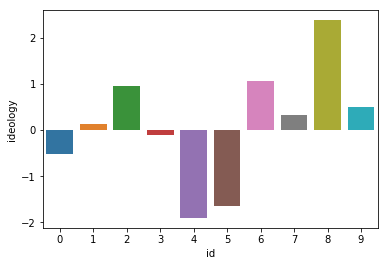

Politician Ideology


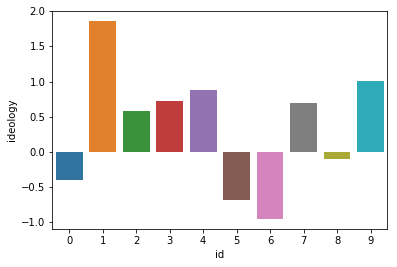

Contributor funds


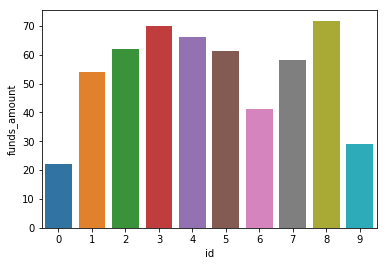

Politician funds


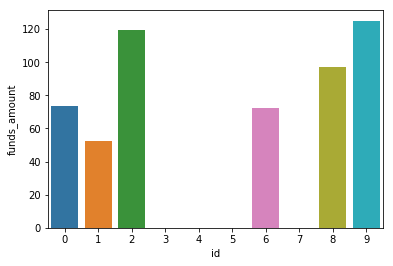

'\n\n\n'

In [331]:
# Visualization currently not doing a great job showing relationship but you can quickly check what's going on. 

print('Contributor Ideology')
sns.barplot(x='id', y='ideology', data=cont_df)
plt.show()

print('Politician Ideology')
sns.barplot(x='id', y='ideology', data=poli_df)
plt.show()

print('Contributor funds')
sns.barplot(x='id', y='funds_amount', data=cont_df)
plt.show()

print('Politician funds')
sns.barplot(x='id', y='funds_amount', data=poli_df)
plt.show()

# Scratch cells

In [148]:
list(model.schedule.agents_by_breed.items())[0]

(__main__.Contributor,
 {0: <__main__.Contributor at 0x116ec5588>,
  1: <__main__.Contributor at 0x116ec5748>,
  2: <__main__.Contributor at 0x116ec5978>,
  3: <__main__.Contributor at 0x116fbf6a0>,
  4: <__main__.Contributor at 0x116fbf400>,
  5: <__main__.Contributor at 0x116fbf828>,
  6: <__main__.Contributor at 0x116fbf668>,
  7: <__main__.Contributor at 0x116fbff28>,
  8: <__main__.Contributor at 0x116fbffd0>,
  9: <__main__.Contributor at 0x116fbf748>})

In [125]:
politician_ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

,id,amount
0,0,29
1,1,17
2,2,17
3,3,22
4,4,12
5,5,24
6,6,16
7,7,21
8,8,18
9,9,24


In [164]:
ref = 0
a = list(dict(list(model.schedule.agents_by_breed.items())[1][1]).values())


In [168]:
politician_ideologies

[0.42819531299676783,
 -1.1632237579132205,
 0.05515820016792025,
 -0.5044792462356746,
 1.0376220538164604,
 -1.0573050337753083,
 -1.0691097848838544,
 -1.0679040353534406,
 0.6430629555186069,
 2.104655995224139]

In [231]:
max(range(len(politician_ideologies)), key=lambda i: abs(politician_ideologies[i]-0))

9